# Exploratory Data Analisys #

In [83]:
# Python
from datetime import datetime
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore') 

# thrid part
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format
import re
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set_theme(style="darkgrid")

# Time series
from fbprophet import Prophet
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, ARMA

# Support helper and deep learning functions
from support import HelperFunc as HF
from support.HelperFunc import add_value_labels
from support import DeepLearnFunc as DL

In [84]:
# Load data

FILEPATH = './data/Backup_orders_after_preparation.csv'

try:
    df = HF.load_orders(FILEPATH)
    print(df.shape)
except Exception as e:
    print(e)

(9781, 49)


In [85]:
# Filter data by date using a widget

date_start = widgets.DatePicker(
    description='Start date',
    disabled=False,
    value = datetime(2021,1,1)
)

date_end = widgets.DatePicker(
    description='End date',
    disabled=False,
    value = datetime.today()
) 

display(date_start, date_end)

DatePicker(value=datetime.datetime(2021, 1, 1, 0, 0), description='Start date')

DatePicker(value=datetime.datetime(2021, 7, 9, 14, 45, 44, 124880), description='End date')

In [86]:
def make_date(date):
    return (date.value.year, date.value.month, date.value.day)

DATE_START = make_date(date_start)
DATE_END = make_date(date_end)

# orders dataframe
df1 = HF.make_pivot_orders(
                    df
                    , period = 'M'
                    , date_start = DATE_START
                    , date_end = DATE_END
                    , drill_down = ['Billing Company'] #only header info, always start with 'Billing Company'
                    )

# orders details dataframe
df2 = HF.make_pivot_orderlines(
                        df
                        , period='Q'
                        , date_start = DATE_START
                        , date_end = DATE_END
#                         , df_filter=df['OrderId'].isin(df.loc[df['Agent'] == 'CH1','OrderId'])
                        , drill_down = ['Lineitem model','Lineitem sku']
                        )

# Show pivot tables in widget
HF.plot_pivot_orders(df1, df2)

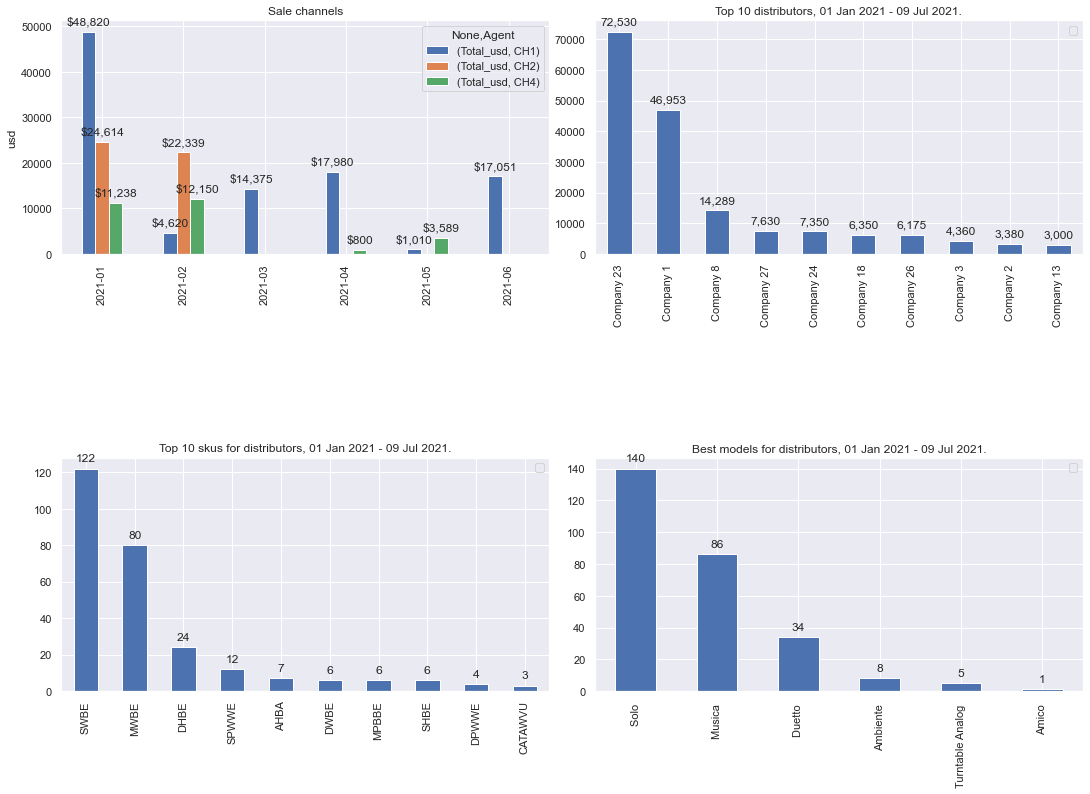

In [87]:
# Plot dshboard

HF.plot_dashboard(df, DATE_START, DATE_END, period='M', figsize=(15,10), h_pad=15)

In [88]:
# Extract different timeseries for the sale channels

TODAY = datetime.today()
DATE_START_HISTORY = (2017,1,1)
DATE_END_HISTORY = (TODAY.year,TODAY.month,TODAY.day)

# Helper function - RESAMPLES on a MONTHLY BASIS (no need to interpolate because that's how the original data are)
df3 = HF.make_pivot_orders_channel(
                    df
                    , period = 'M'
                    , date_start = DATE_START_HISTORY
                    , date_end = DATE_END_HISTORY
                    , roll = 12
                    )

In [89]:
# Descriptive statistics

df3.describe().T

,count,mean,std,min,25%,50%,75%,max
CH1,54.00,"5,709.03","10,036.43",0.00,0.00,0.00,"6,671.50","48,820.00"
CH2,54.00,"7,061.05","12,667.42",0.00,0.00,0.00,"13,026.96","50,312.80"
CH3,54.00,"11,522.25","17,188.00",0.00,0.00,788.00,"16,065.74","75,285.11"
CH4,54.00,"24,035.39","27,012.89",0.00,"4,326.70","13,745.80","34,937.23","102,199.86"
Total,54.00,"48,327.71","38,650.84",0.00,"18,074.57","42,962.74","62,545.23","183,124.20"
CH1_diff,53.00,321.72,"10,007.76","-44,200.00",0.00,0.00,"1,340.00","25,761.00"
CH2_diff,53.00,0.00,"15,067.55","-48,392.80",0.00,0.00,0.00,"50,312.80"
CH3_diff,53.00,-0.00,"22,359.80","-58,206.26","-8,244.34",0.00,"6,599.46","75,285.11"
CH4_diff,53.00,-39.83,"32,318.58","-91,953.50","-13,404.39",-730.23,"11,964.00","87,909.39"
Total_diff,53.00,281.88,"48,435.89","-151,815.54","-27,159.60","2,317.41","12,827.71","130,317.15"


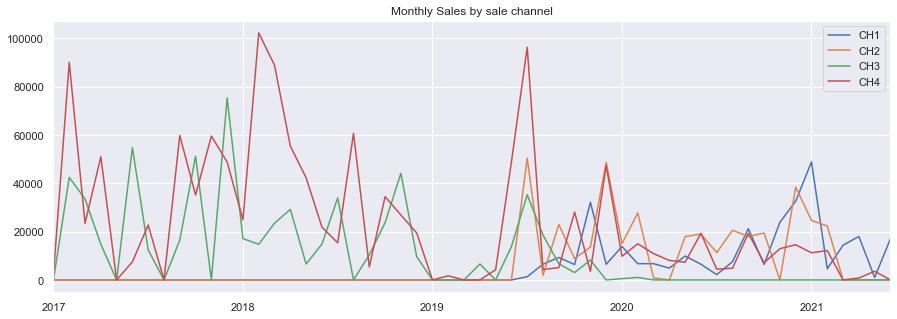

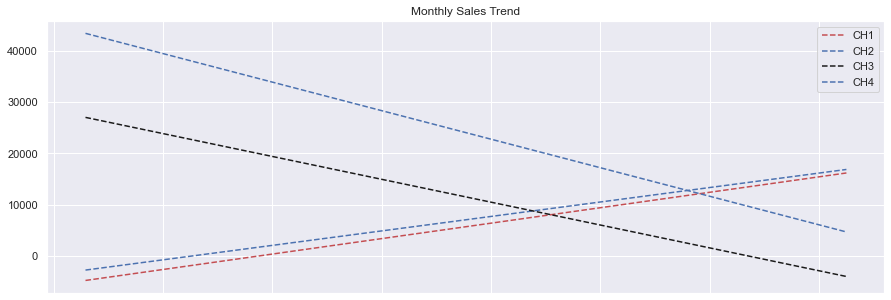

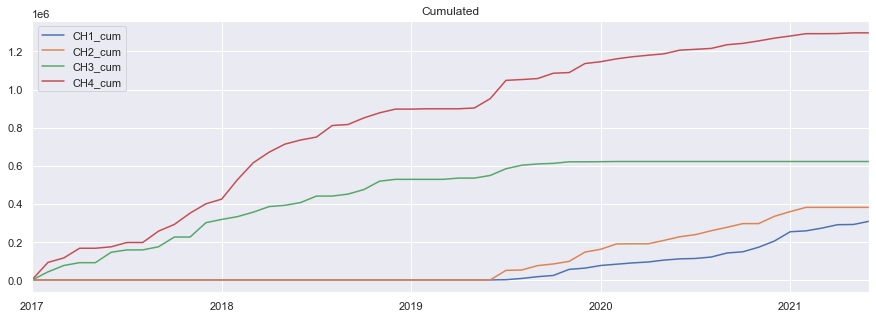

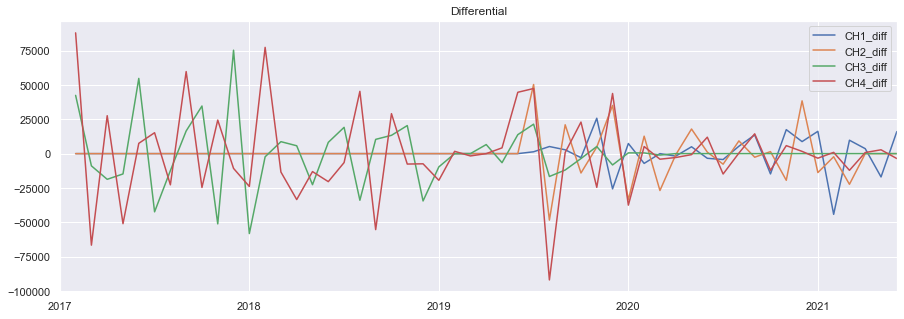

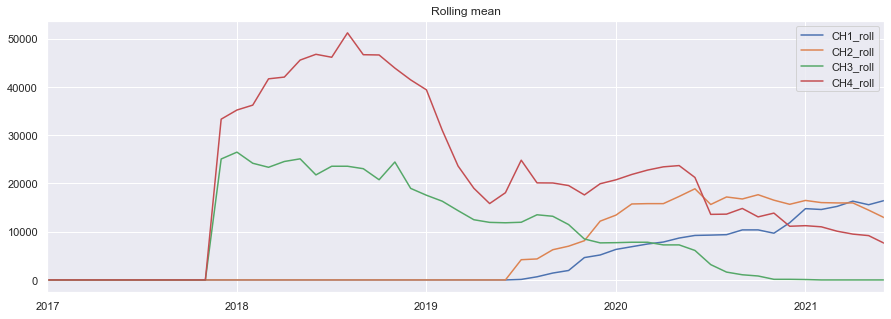

In [90]:
# Plot different sales reports for the 4 channels

figsize=(15,5)

CHANNELS = ['CH1','CH2','CH3', 'CH4']
CHANNELS_CUM = ['CH1_cum','CH2_cum','CH3_cum', 'CH4_cum']
CHANNELS_DIFF = ['CH1_diff','CH2_diff','CH3_diff', 'CH4_diff']
CHANNELS_ROLL = ['CH1_roll','CH2_roll','CH3_roll', 'CH4_roll']

df3[CHANNELS].plot(title='Monthly Sales by sale channel', figsize=figsize)

fig = plt.figure(figsize=figsize)
ax = plt.gca()
for a, c in zip(CHANNELS, ['r','b','k','b']):
    X = df3[[a]].index.values.astype('float')
    z = np.reshape(np.polyfit(X, df3[[a]], 1), (-1,))
    p = np.poly1d(z)
    ax.plot(X, p(X),c + "--")
ax.set_title('Monthly Sales Trend')
ax.legend(CHANNELS)
ax.set_xticklabels('') ##

df3[CHANNELS_CUM].plot(title='Cumulated', figsize=figsize)

df3[CHANNELS_DIFF].plot(title='Differential', figsize=figsize)

df3[CHANNELS_ROLL].plot(title='Rolling mean', figsize=figsize)

plt.show()

In [91]:
# Define the timeseries as the Total sales

timeseries = df3.Total

,mean_vals,var_vals
0,"63,813.09","2,854,323,944.82"
1,"42,679.94","912,891,593.34"
2,"37,101.22","970,269,765.07"
3,"89,936.07","700,745,830.06"
4,"90,396.08","1,177,856,381.27"
5,"56,690.22","412,861,769.56"
6,"41,906.68","363,756,995.33"
7,"52,742.65","306,821,059.68"
8,571.79,"631,272.78"
9,"24,478.39","729,339,873.63"


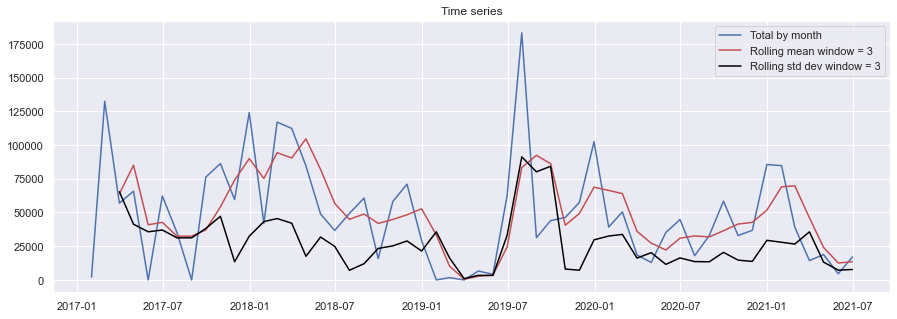

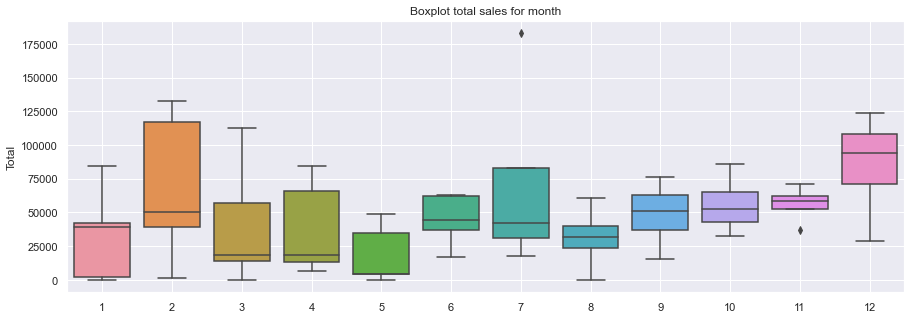

In [92]:
# Plot mean, variance, and rolling statistics

WINDOW = 3 # MONTHS

figsize=(15,5)

# Split the total into chunks
chunks = np.split(timeseries, indices_or_sections=18) ## 

# Calculate and display mean and variance
mean_vals = np.mean(chunks,axis=1)
var_vals = np.var(chunks,axis=1)
vals = {'mean_vals': mean_vals , 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
display(mean_var)

# Plot the data adding resample on a quarterly base and rolling view
fig = plt.figure(figsize=figsize)
plt.plot(timeseries, 'b')
# plt.plot(timeseries.resample('Q').mean(), 'g')
plt.plot(timeseries.rolling(window=WINDOW).mean(), 'r')
plt.plot(timeseries.rolling(window=WINDOW).std(), 'black')
plt.title('Time series')
plt.legend(['Total by month', 'Rolling mean window = {}'.format(WINDOW), 'Rolling std dev window = {}'.format(WINDOW)])
plt.show()

# Boxplot to show the mean and variance trend
fig = plt.figure(figsize=figsize)
ax = sns.boxplot(x=timeseries.index.month, y=timeseries)
ax.set_title('Boxplot total sales for month')
plt.grid(b=True)
plt.show()

NormaltestResult(statistic=14.118261621909, pvalue=0.0008595248589791014) 

Dickey-Fuller test:
Index: -5.802923
p-value: 4.586308720283926e-07
Number of observations: 53
Critical values: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


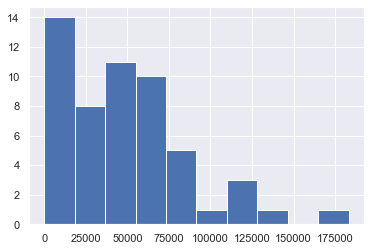

In [101]:
# Plot histo
timeseries.hist();

# Scipy normal test where the Null hypothesis is that the distribution is normal
print(stats.normaltest(timeseries, nan_policy='raise'),'\n')

# Dickey-Fuller test where the Null hypothesis is that the data is not stationary
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(timeseries)
print('Dickey-Fuller test:\nIndex: {:4f}'.format(adf))
print('p-value: {}'.format(pvalue))
print('Number of observations: {}'.format(nobs))
print('Critical values: {}'.format(critical_values))

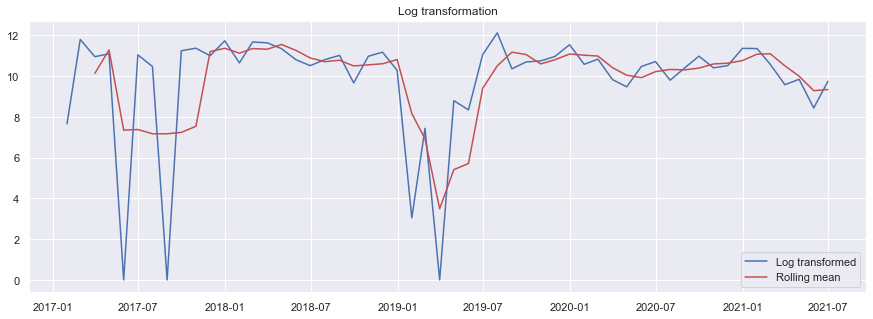

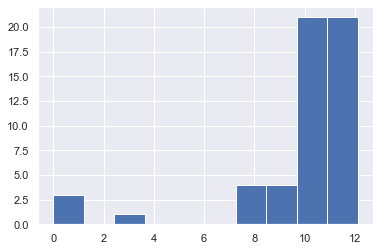

NormaltestResult(statistic=49.24243314483155, pvalue=2.028343500881349e-11)
Dickey-Fuller test:
Index: -2.956629
p-value: 0.039148001424211445
Number of observations: 50
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


In [102]:
# Log transofrmation - reduce trend?

new_timeseries = np.log1p(timeseries)

plt.figure(figsize=(15,5))
plt.plot(new_timeseries, 'b', label='Log transformed')
plt.plot(new_timeseries.rolling(window=WINDOW).mean(), 'r', label='Rolling mean')
plt.title('Log transformation')
plt.legend(loc='best')
plt.show()

# Plot histo
pd.Series(new_timeseries).hist()
plt.show()

# Scipy normal test where the Null hypothesis is that the distribution is normal
print(stats.normaltest(new_timeseries))

# Dickey-Fuller test where the Null hypothesis is that the data is not stationary
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(new_timeseries)
print('Dickey-Fuller test:\nIndex: {:4f}'.format(adf))
print('p-value: {}'.format(pvalue))
print('Number of observations: {}'.format(nobs))
print('Critical values: {}'.format(critical_values))

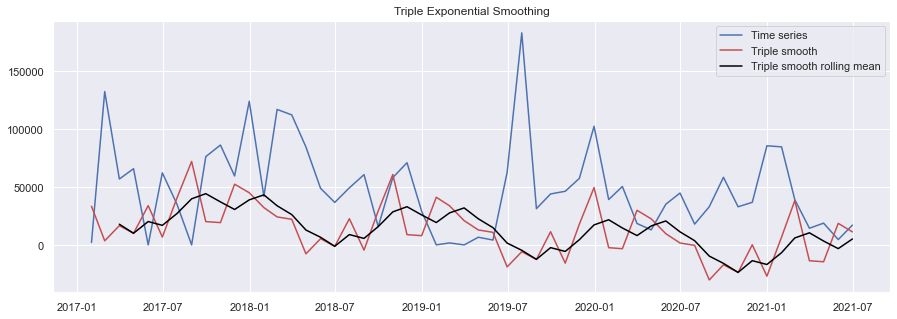

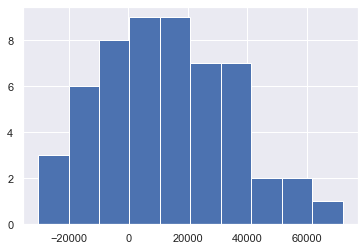

NormaltestResult(statistic=1.0162976539369806, pvalue=0.6016082295701024)
Dickey-Fuller test:
Index: -2.238077
p-value: 0.19271704903125286
Number of observations: 51
Critical values: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}


In [104]:
# Triple exponential smoothing - reduce trend?

y = timeseries.values
X = timeseries.index.values

test_size = 3 # MONTHS

X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

# optimize for different periods
periods = [2,3,4,6,8,10,12,13,14,15,16,17,18]
mse = [] 

# From EDA I assume additive trend and seasonality
for p in periods:
    triple = ExponentialSmoothing(y_train,
                                  trend="additive",
                                  seasonal="additive",
                                  seasonal_periods=p).fit(optimized=True)

    preds_3 = triple.forecast(len(y_test))
    mse.append(((y_test-preds_3)**2).sum()/len(y_test)) # Mean Square Error
    
mse_df = pd.DataFrame({'periods': periods, 'mse': mse})

# Dataframe which shows the period with lowest mse
# display(mse_df.set_index('periods').style.format('{:,e}'))

# Fit the smoothing with lowest mse
triple = ExponentialSmoothing(y_train,
                                  trend="additive",
                                  seasonal="additive",
                                  seasonal_periods=mse_df.loc[mse_df.mse.idxmin(axis=0), 'periods']).fit(optimized=True)


triple_forecast = triple.forecast(len(y))

plt.figure(figsize=(15,5))
plt.plot(timeseries, 'b', label='Time series')
plt.plot(X, triple_forecast,'r', label='Triple smooth')
plt.plot(X, pd.Series(triple_forecast).rolling(window=WINDOW).mean(), 'black', label='Triple smooth rolling mean')
plt.title('Triple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

# Plot histo
pd.Series(triple_forecast).hist()
plt.show()

# Scipy normal test where the Null hypothesis is that the distribution is normal
print(stats.normaltest(triple_forecast))

# Dickey-Fuller test where the Null hypothesis is that the data is not stationary
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(triple_forecast)
print('Dickey-Fuller test:\nIndex: {:4f}'.format(adf))
print('p-value: {}'.format(pvalue))
print('Number of observations: {}'.format(nobs))
print('Critical values: {}'.format(critical_values))

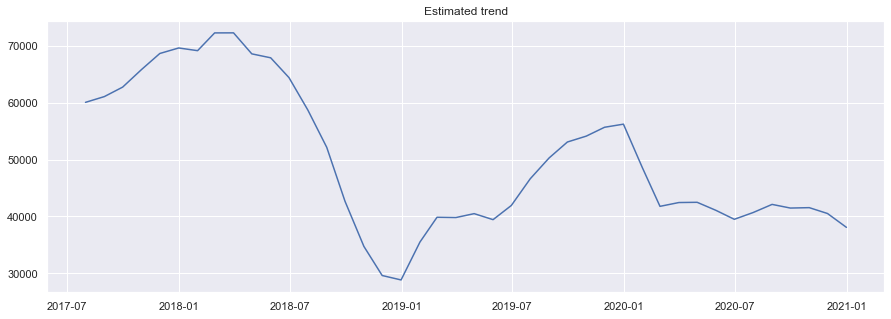

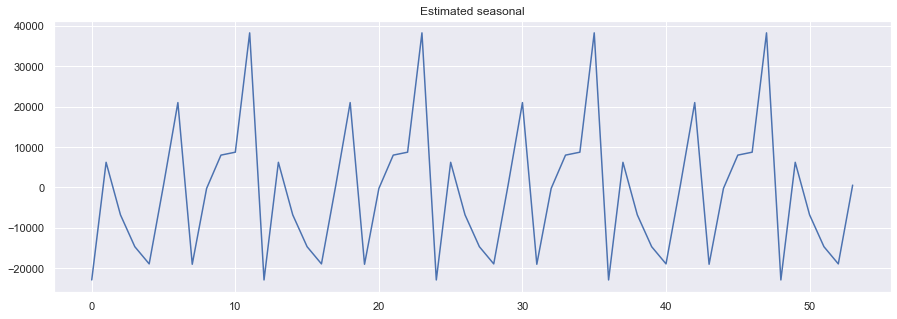

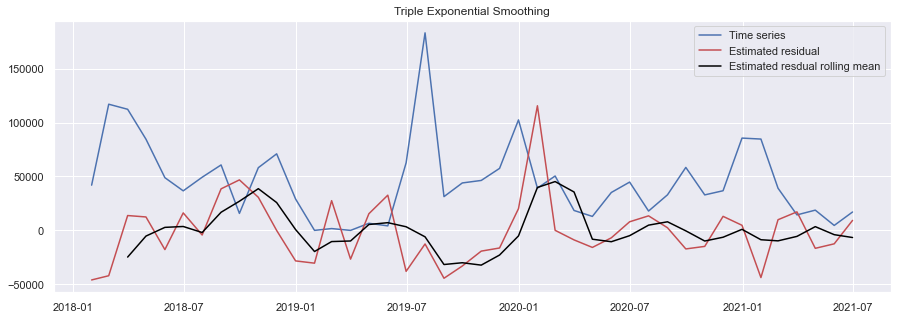

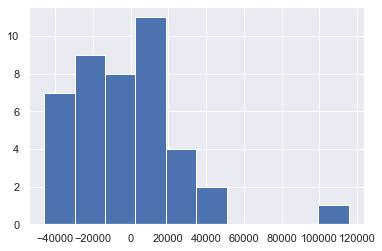

NormaltestResult(statistic=19.703088020229323, pvalue=5.266581365742102e-05)
Dickey-Fuller test:
Index: -5.249585
p-value: 6.958079976510259e-06
Number of observations: 41
Critical values: {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}


In [105]:
# decompose trend and seasonal parts

PERIOD = 12 # assumption based on the previous plots
ss_decomposition = seasonal_decompose(x=np.array(timeseries), model='additive', period=PERIOD) 
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid[np.logical_not(np.isnan(ss_decomposition.resid))] ## remove nan

figsize=(15,5)

plt.figure(figsize=figsize)
plt.plot(timeseries.index, estimated_trend)
plt.title('Estimated trend')
plt.show()

plt.figure(figsize=figsize)
plt.plot(estimated_seasonal)
plt.title('Estimated seasonal')
plt.show()


plt.figure(figsize=figsize)
plt.plot(timeseries[-42:], 'b', label='Time series')
plt.plot(timeseries[-42:].index, estimated_residual, 'r', label='Estimated residual')
plt.plot(timeseries[-42:].index, pd.Series(estimated_residual).rolling(window=WINDOW).mean(), 'black', label='Estimated resdual rolling mean')
plt.title('Triple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

# Plot histo
pd.Series(estimated_residual).hist()
plt.show()

# Scipy normal test where the Null hypothesis is that the distribution is normal
print(stats.normaltest(estimated_residual))

# Dickey-Fuller test where the Null hypothesis is that the data is not stationary
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(estimated_residual)
print('Dickey-Fuller test:\nIndex: {:4f}'.format(adf))
print('p-value: {}'.format(pvalue))
print('Number of observations: {}'.format(nobs))
print('Critical values: {}'.format(critical_values))

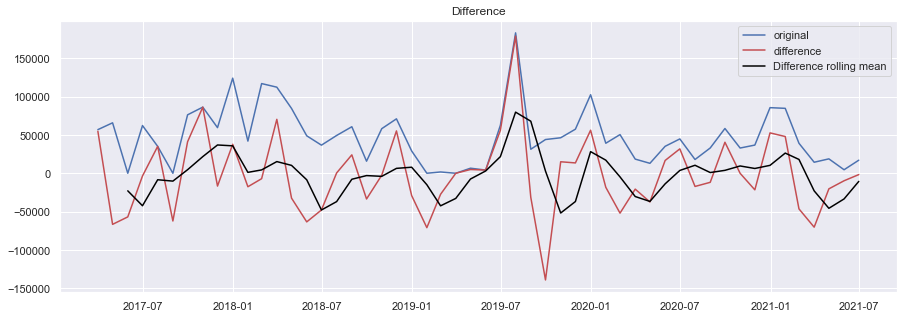

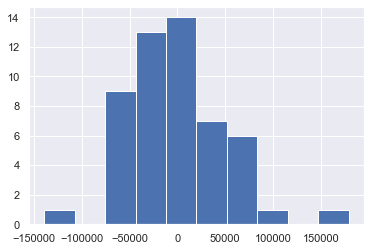

NormaltestResult(statistic=9.659864617973982, pvalue=0.007987061899968239)
Dickey-Fuller test:
Index: -4.532701
p-value: 0.0001715491616437357
Number of observations: 46
Critical values: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}


In [106]:
# Differencing on estimated residuals without log transformation

DIFF = 2

difference = np.array(timeseries)[DIFF:]-np.array(timeseries)[:-DIFF]

fig = plt.figure(figsize=(15,5))
plt.plot(timeseries[DIFF:], label ='original', color='b')
plt.plot(timeseries[DIFF:].index, difference, label = 'difference', color='r')
plt.plot(timeseries[DIFF:].index, pd.Series(difference).rolling(window=WINDOW).mean(), 'black', label='Difference rolling mean')
plt.title('Difference')
plt.legend()
plt.show()

# Plot histo
pd.Series(difference).hist()
plt.show()

# Scipy normal test where the Null hypothesis is that the distribution is normal
print(stats.normaltest(difference))

# Dickey-Fuller test where the Null hypothesis is that the data is not stationary
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(difference)
print('Dickey-Fuller test:\nIndex: {:4f}'.format(adf))
print('p-value: {}'.format(pvalue))
print('Number of observations: {}'.format(nobs))
print('Critical values: {}'.format(critical_values))